### Local Setup

In [1]:
from pathlib import Path
import sys

# Make this path be the project's "base" directory, so we can include modules
notebook_directory_ancestor = Path.cwd().resolve().parent.parent.parent.parent
print(notebook_directory_ancestor)
core_code_directory = notebook_directory_ancestor / "PythonLibraries" / "CoreCode"

is_core_code_directory_in_sys_path = str(core_code_directory) in sys.path
is_notebook_directory_ancestor_in_sys_path = str(notebook_directory_ancestor) in sys.path
print("Is CoreCode directory in sys.path?", is_core_code_directory_in_sys_path)
print("Is notebook directory's ancestor in sys.path?", is_notebook_directory_ancestor_in_sys_path)

if not is_core_code_directory_in_sys_path:
    sys.path.append(str(core_code_directory))
    
from corecode.Utilities import (
    DataSubdirectories,
    )
data_sub_dirs = DataSubdirectories()

/InServiceOfX
Is CoreCode directory in sys.path? False
Is notebook directory's ancestor in sys.path? False


In [2]:
instant_id_path = notebook_directory_ancestor.parent / "ThirdParty" / "InstantID"
if (instant_id_path.exists() and str(instant_id_path) not in sys.path):
    sys.path.append(str(instant_id_path))

In [3]:
more_insight_face_directory = notebook_directory_ancestor / "PythonLibraries" / "ThirdParties" / "MoreInsightFace"
if (more_insight_face_directory.exists() and str(more_insight_face_directory) not in sys.path):
    sys.path.append(str(more_insight_face_directory))
    print("added MoreInsightFace")

added MoreInsightFace


In [4]:
controlnet_path = data_sub_dirs.ModelsDiffusion / "InstantX" / "InstantID" / "ControlNetModel"
print(controlnet_path.exists())

True


In [5]:
from diffusers.models import ControlNetModel
from diffusers.utils.torch_utils import is_compiled_module
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

If you make this torch_dtype=torch.float16 for ControlNet, then at when InstantID's StableDiffusionXL... class calls .encode_prompt(..), this error is obtained below. This is because if we choose .to("cuda"), we run out of VRAM on our local GPU. But if we choose "cpu" or "cpu offloading", because the CPU doesn't know the type float16 nor know how to process it, it'll result in this.
```
File /usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2548, in layer_norm(input, normalized_shape, weight, bias, eps)
   2544 if has_torch_function_variadic(input, weight, bias):
   2545     return handle_torch_function(
   2546         layer_norm, (input, weight, bias), input, normalized_shape, weight=weight, bias=bias, eps=eps
   2547     )
-> 2548 return torch.layer_norm(input, normalized_shape, weight, bias, eps, torch.backends.cudnn.enabled)

RuntimeError: "LayerNormKernelImpl" not implemented for 'Half'
```    

In [6]:
# See diffusers/models/controlnet.py and __init__(..)
controlnet = ControlNetModel.from_pretrained(
    controlnet_path,
    #torch_dtype=torch.float16,
    use_safetensors=True,
    local_files_only=True)

In [6]:
isinstance(controlnet, ControlNetModel)

True

In [9]:
help(is_compiled_module)

Help on function is_compiled_module in module diffusers.utils.torch_utils:

is_compiled_module(module) -> bool
    Check whether the module was compiled with torch.compile()



In [11]:
is_compiled_module(controlnet)

False

In [12]:
controlnet.config

FrozenDict([('in_channels', 4),
            ('conditioning_channels', 3),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['DownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('only_cross_attention', False),
            ('block_out_channels', [320, 640, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attention_dim', 2048),
            ('transformer_layers_per_block', [1, 2, 10]),
            ('encoder_hid_dim', None),
            ('encoder_hid_dim_type', None),
            ('attention_head_dim', [5, 10, 20]),
            ('num_attention_heads', None),
            ('use_linear_projection', True),
            ('class_embed_type', None),
    

In [16]:
controlnet.config.global_pool_conditions

False

In [17]:
controlnet.dtype

torch.float16

In [7]:
from pipeline_stable_diffusion_xl_instantid import StableDiffusionXLInstantIDPipeline

self.do_classifier_free_guidance is not defined as a class member that is inherited in, say, an __init__() or a class member function, rather, it is decorated with @property as a class member function that takes as input `self`. This property is not inherited, but manually copied for each Python class that needs it.

See for example pipeline_stable_diffusion_xl.py in pipelines/stable_diffusion_xl of diffusers, but there are multiple examples of this.

Recall that 
```
    @property
    def do_classifier_free_guidance(self):
        return self._guidance_scale > 1 and self.unet.config.time_cond_proj_dim is None
```


In [10]:
StableDiffusionXLInstantIDPipeline.do_classifier_free_guidance

NameError: name 'StableDiffusionXLInstantIDPipeline' is not defined

In [8]:
model_subdir = data_sub_dirs.ModelsDiffusion / "fluently" / "Fluently-XL-v4"
print(model_subdir)
print(model_subdir.exists())

/Data/Models/Diffusion/fluently/Fluently-XL-v4
True


For torch_dtype, *if* you set torch_dtype=torch.float16, the device has to be "cuda" and not "cpu" because otherwise, you get the error:

```
-> 2548 return torch.layer_norm(input, normalized_shape, weight, bias, eps, torch.backends.cudnn.enabled)

RuntimeError: "LayerNormKernelImpl" not implemented for 'Half'
```

In [9]:
%time
pipe = StableDiffusionXLInstantIDPipeline.from_pretrained(
    str(model_subdir),
    controlnet=controlnet,
    #revision="fp16",
    # If workload is CPU or offloaded to CPU, can't allow this type.
    #torch_dtype=torch.float16,
    local_files_only=True,)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 5.96 µs


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

cached_folder:  /Data/Models/Diffusion/fluently/Fluently-XL-v4
name:  scheduler
{}
cached_folder:  /Data/Models/Diffusion/fluently/Fluently-XL-v4
name:  text_encoder
{'torch_dtype': None, 'device_map': None, 'max_memory': None, 'offload_folder': None, 'offload_state_dict': False, 'low_cpu_mem_usage': True}
cached_folder:  /Data/Models/Diffusion/fluently/Fluently-XL-v4
name:  tokenizer
{}
cached_folder:  /Data/Models/Diffusion/fluently/Fluently-XL-v4
name:  text_encoder_2
{'torch_dtype': None, 'device_map': None, 'max_memory': None, 'offload_folder': None, 'offload_state_dict': False, 'low_cpu_mem_usage': True}
cached_folder:  /Data/Models/Diffusion/fluently/Fluently-XL-v4
name:  vae
{'torch_dtype': None, 'device_map': None, 'max_memory': None, 'offload_folder': None, 'offload_state_dict': False, 'variant': None, 'low_cpu_mem_usage': True}
cached_folder:  /Data/Models/Diffusion/fluently/Fluently-XL-v4
name:  tokenizer_2
{}
cached_folder:  /Data/Models/Diffusion/fluently/Fluently-XL-v4
n

In [11]:
#pipe.to("cuda")

"""
I obtained this error:

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 7.79 GiB of which 35.44 MiB is free. Process 99163 has 6.58 GiB memory in use. Of the allocated memory 6.24 GiB is allocated by PyTorch, and 214.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

"""

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 7.79 GiB of which 35.44 MiB is free. Process 99163 has 6.58 GiB memory in use. Of the allocated memory 6.24 GiB is allocated by PyTorch, and 214.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

The attribute `self._guidance_scale` and therefore also properties `do_classifier_free_guidance` only come into existence on a `__call__` call, see pipelines/controlnet/pipeline_controlnet_sd_xl.py and `__call__` function definition for the class. Also notice that do_classifier_free_guidance is defined as a class member function and decorated with a `@property` - treat this as syntactic sugar at a rudimentary level.

Also, note that guidance scale comes in as an optional parameter in the call function, with default value at 5.0.

In [53]:
# AttributeError
# AttributeError: 'StableDiffusionXLInstantIDPipeline' object has no attribute '_guidance_scale'
#print(pipe.do_classifier_free_guidance)
#print(type(pipe.do_classifier_free_guidance))
#print(pipe._guidance_scale())
#print(type(pipe._guidance_scale))

# AttributeError: 'StableDiffusionXLInstantIDPipeline' object has no attribute '_guidance_scale'
#StableDiffusionXLInstantIDPipeline.do_classifier_free_guidance.__get__(pipe)

#AttributeError: 'StableDiffusionXLInstantIDPipeline' object has no attribute '_guidance_scale'
#StableDiffusionXLInstantIDPipeline.guidance_scale.__get__(pipe)

# AttributeError: 'StableDiffusionXLInstantIDPipeline' object has no attribute '_guidance_scale'
#pipe._guidance_scale

In [55]:
print(pipe.unet.config.time_cond_proj_dim)
print(type(pipe.unet.config.time_cond_proj_dim))

None
<class 'NoneType'>


guess_mode is default False in `__call__` in pipeline_stable_diffusion_xl_instantid.py of InstantID.

In [57]:
global_pool_conditions = (
    controlnet.config.global_pool_conditions
    if isinstance(controlnet, ControlNetModel)
    else controlnet.nets[0].config.global_pool_conditions)
print(global_pool_conditions)
print(type(global_pool_conditions))
guess_mode = False
guess_mode = guess_mode or global_pool_conditions
print(guess_mode)

False
<class 'bool'>
False


Recall in InstantID.pipeline_stable_diffusion_xl_instantid.py,

```
    @torch.no_grad()
    @replace_example_docstring(EXAMPLE_DOC_STRING)
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        prompt_2: Optional[Union[str, List[str]]] = None,
        image: PipelineImageInput = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        guidance_scale: float = 5.0,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        negative_prompt_2: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        image_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        controlnet_conditioning_scale: Union[float, List[float]] = 1.0,
        guess_mode: bool = False,
        control_guidance_start: Union[float, List[float]] = 0.0,
        control_guidance_end: Union[float, List[float]] = 1.0,
        original_size: Tuple[int, int] = None,
        crops_coords_top_left: Tuple[int, int] = (0, 0),
        target_size: Tuple[int, int] = None,
        negative_original_size: Optional[Tuple[int, int]] = None,
        negative_crops_coords_top_left: Tuple[int, int] = (0, 0),
        negative_target_size: Optional[Tuple[int, int]] = None,
        clip_skip: Optional[int] = None,
        callback_on_step_end: Optional[Callable[[int, int, Dict], None]] = None,
        callback_on_step_end_tensor_inputs: List[str] = ["latents"],

        # IP adapter
        ip_adapter_scale=None,

        **kwargs,
    ):
```
and

```
		images = pipe(
			prompt=prompt,
			negative_prompt=negative_prompt,
			image_embeds=face_information.face_embedding,
            # keypoints are from a "pose" image
            image=keypoints,
			controlnet_conditioning_scale=float(controlnet_conditioning_scale),
			num_inference_steps=number_of_steps,
            # Height, width are both from the "pose" image
            height=height,
			width=width).images
```

In [10]:
from moreinsightface.Wrappers import get_face_and_pose_info_from_images#FaceAnalysisWrapper

In [11]:
original_default_det_result = get_face_and_pose_info_from_images(
    "antelopev2",
    "/Data/Models/Diffusion/InstantX",
    data_sub_dirs.Public / "Images" / "Playboy" / "LennaSjööblom_LenaForsén" / "qShFGgyfM2o8OTptV6bGyf_9QVDc7x2ua38DJyWci9nsRi8u2ZJunn27MMP8vji6wZmUna5cR7TDxpC_p1wrzVinINlkVsl8tB6JY3RF81L9bAU38H4N-EQwDtEWWUT2.jpeg",
    data_sub_dirs.Public / "Images" / "Playboy" / "TeddiSmith" / "tumblr_oythctEdBF1wykvxvo1_1280.jpg",
    det_size=640)

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'prefer_nhwc': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_max_tuning_duration_ms': '0', 'use_ep_level_unified_stream': '0', 'tunable_op_enable': '0', 'enable_cuda_graph': '0', 'cudnn_conv_use_max_workspace': '1', 'do_copy_in_default_stream': '1', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'gpu_external_empty_cache': '0', 'gpu_external_free': '0', 'tunable_op_tuning_enable': '0', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_external_alloc': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'has_user_compute_stream': '0', 'gpu_mem_limit': '18446744073709551615', 'device_id': '0'}}
find model: /Data/Models/Diffusion/InstantX/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'prefer_nhwc': '0'

/ThirdParty/insightface/python-package/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


In [12]:
original_default_det_result

(FaceInformation(face_embedding=array([-2.19255030e-01, -4.89995956e-01,  3.46210822e-02,  8.99958313e-01,
        -1.32275462e+00, -1.37653565e+00,  4.01281342e-02,  3.18349041e-02,
        -2.38527536e-01,  3.02093150e-03, -2.91089982e-01,  1.53613031e+00,
        -8.68161678e-01, -1.37864041e+00, -1.28862226e+00,  6.11500219e-02,
        -5.59473693e-01, -1.99329153e-01, -3.25344861e-01, -6.15891218e-01,
        -2.01442385e+00,  7.32915044e-01,  1.88947833e+00, -2.76678298e-02,
        -6.77791595e-01, -2.62548566e-01, -6.97107315e-01, -1.68059945e+00,
         1.85134113e+00, -1.02117407e+00, -5.34121692e-01,  3.48018467e-01,
         3.59841108e-01, -5.53745508e-01,  1.05247176e+00,  2.58443832e-01,
        -1.02241564e+00, -7.81964898e-01, -1.46076393e+00, -5.42179942e-01,
         6.76389098e-01, -1.02049577e+00,  5.61810732e-01, -1.35541391e+00,
        -1.43527448e+00,  6.03798367e-02, -1.34801853e+00,  1.86807171e-01,
         5.03632128e-02,  2.38811076e-01,  3.92950267e-01

In [12]:
image_embeds = original_default_det_result[0].face_embedding
print(type(image_embeds))
print(image_embeds.shape)
image_keypoints = original_default_det_result[1].pose_keypoints
print(type(image_keypoints))
height = original_default_det_result[1].height
print(type(height))
print(height)
width = original_default_det_result[1].width
print(type(width))
print(width)

<class 'numpy.ndarray'>
(512,)
<class 'PIL.Image.Image'>
<class 'int'>
800
<class 'int'>
773


In [13]:
#if prompt is not None and isinstance(prompt, str):
batch_size = 1
#default value in this input
num_images_per_prompt = 1

print(type(pipe._execution_device))
print(pipe._execution_device)

<class 'torch.device'>
cpu


In [14]:
# See https://x.com/bri_guy_ai/status/1792915142096670830
prompt="A pair of woman with black lipstick and futuristic eyewear wearing a matte leather techwear outfit is depicted in the style of street fashion photography., featuring architectural details like glass blocks and metal beams, shot on a Sony Alpha A7 III camera with an f/8 aperture setting."
negative_prompt="(deformed iris, deformed pupils, cgi, 3d, render, sketch, cartoon, drawing, anime, mutated hands and fingers:1.4), (deformed, distorted, disfigured:1.3), poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, disconnected limbs, mutation, mutated, ugly, disgusting, amputation, worst quality, low quality, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, beard, bearded face, facial hair, giant balloon boobs, double D breasts, (mutated hands and fingers:1.4)"

In [15]:
# 3.1 Encode input prompt
# Default value in input argument is None
text_encoder_lora_scale = None
(
    prompt_embeds,
    negative_prompt_embeds,
    pooled_prompt_embeds,
    negative_pooled_prompt_embeds,
) = pipe.encode_prompt(
    prompt,
    # prompt_2 default value is None
    None,
    # device
    pipe._execution_device,
    num_images_per_prompt,
    # self.do_classifier_free_guidance
    True,
    negative_prompt,
    # negative_prompt_2
    None,
    prompt_embeds=None,
    negative_prompt_embeds=None,
    pooled_prompt_embeds=None,
    lora_scale = None,
    # clip_skip: Optional[int] = None in input arguments
    clip_skip= None)
print(type(prompt_embeds))
print(prompt_embeds.size())
print(prompt_embeds)
print(type(negative_prompt_embeds))
print(negative_prompt_embeds.size())
print(negative_prompt_embeds)
print(type(pooled_prompt_embeds))
print(pooled_prompt_embeds.size())
print(pooled_prompt_embeds)
print(type(negative_pooled_prompt_embeds))
print(negative_pooled_prompt_embeds.size())
print(negative_pooled_prompt_embeds)

# **IF** you set torch_dtype= float16, then the following is obtained:
"""
File /usr/local/lib/python3.10/dist-packages/torch/nn/modules/normalization.py:196, in LayerNorm.forward(self, input)
    195 def forward(self, input: Tensor) -> Tensor:
--> 196     return F.layer_norm(
    197         input, self.normalized_shape, self.weight, self.bias, self.eps)

File /usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2548, in layer_norm(input, normalized_shape, weight, bias, eps)
   2544 if has_torch_function_variadic(input, weight, bias):
   2545     return handle_torch_function(
   2546         layer_norm, (input, weight, bias), input, normalized_shape, weight=weight, bias=bias, eps=eps
   2547     )
-> 2548 return torch.layer_norm(input, normalized_shape, weight, bias, eps, torch.backends.cudnn.enabled)

RuntimeError: "LayerNormKernelImpl" not implemented for 'Half'
"""

<class 'torch.Tensor'>
torch.Size([1, 77, 2048])
tensor([[[-3.7832, -2.3968,  4.3660,  ...,  0.1819,  0.3964, -0.2885],
         [ 0.1400, -0.6531, -0.4755,  ...,  0.6230, -0.0515, -0.1875],
         [ 1.2391, -1.2450,  0.2034,  ..., -0.0741,  0.6604,  0.3879],
         ...,
         [ 0.2431, -0.1541, -0.1018,  ..., -0.5995,  0.0151,  0.9838],
         [ 0.2358, -0.1544, -0.1001,  ..., -0.6500, -0.0896,  1.0018],
         [ 0.3099, -0.2136, -0.1878,  ..., -0.4197, -0.1246,  0.6815]]],
       grad_fn=<ViewBackward0>)
<class 'torch.Tensor'>
torch.Size([1, 77, 2048])
tensor([[[-3.7832, -2.3968,  4.3660,  ...,  0.1819,  0.3964, -0.2885],
         [-0.1023, -0.4413, -0.2958,  ...,  0.9558, -0.1419, -0.5040],
         [ 0.6752,  0.1802, -0.0561,  ...,  0.0259,  0.4648,  0.0845],
         ...,
         [-0.5209, -0.7037, -0.1644,  ..., -0.0126, -0.2522,  0.0114],
         [-0.6428, -0.2877,  1.2375,  ..., -0.0461,  0.2289, -0.0390],
         [ 0.1557,  0.1864,  0.3326,  ...,  0.3965,  1.4452

'\nFile /usr/local/lib/python3.10/dist-packages/torch/nn/modules/normalization.py:196, in LayerNorm.forward(self, input)\n    195 def forward(self, input: Tensor) -> Tensor:\n--> 196     return F.layer_norm(\n    197         input, self.normalized_shape, self.weight, self.bias, self.eps)\n\nFile /usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2548, in layer_norm(input, normalized_shape, weight, bias, eps)\n   2544 if has_torch_function_variadic(input, weight, bias):\n   2545     return handle_torch_function(\n   2546         layer_norm, (input, weight, bias), input, normalized_shape, weight=weight, bias=bias, eps=eps\n   2547     )\n-> 2548 return torch.layer_norm(input, normalized_shape, weight, bias, eps, torch.backends.cudnn.enabled)\n\nRuntimeError: "LayerNormKernelImpl" not implemented for \'Half\'\n'

If you don't do the following, then when you run pipe._encode_prompt_image_emb (in pipeline_stable_diffusion_xl_instantid.py, look at def set_image_proj_model(..) for self.image_proj_model_in_features, you obtain 

```
File /ThirdParty/diffusers/src/diffusers/configuration_utils.py:143, in ConfigMixin.__getattr__(self, name)
    140     deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
    141     return self._internal_dict[name]
--> 143 raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}'")

AttributeError: 'StableDiffusionXLInstantIDPipeline' object has no attribute 'image_proj_model_in_features')
```

In [16]:
pipe.load_ip_adapter_instantid(
    data_sub_dirs.ModelsDiffusion / "InstantX" / "InstantID" / "ip-adapter.bin",    
    512,
    16,
    0.5)

In [17]:
print(pipe.image_proj_model_in_features)

512


In [32]:
# 3.2 Encode image prompt
# Recall image_embeds is the details of the face.
prompt_image_emb = pipe._encode_prompt_image_emb(image_embeds, 
                                                 device,
                                                 num_images_per_prompt,
                                                 pipe.unet.dtype,
                                                 True)
print(type(prompt_image_emb))
print(prompt_image_emb.shape)
print(prompt_image_emb[:,:2,:3])

<class 'torch.Tensor'>
torch.Size([2, 16, 2048])
tensor([[[-0.0132,  0.0153, -0.0028],
         [-0.0081,  0.0538, -0.0007]],

        [[-0.0049,  0.0058, -0.0019],
         [-0.0052,  0.0057, -0.0022]]], grad_fn=<SliceBackward0>)


In [40]:
# 4. Prepare image
# Recall image comes in as an input into def __call__(..) and in InServiceOfX in generate_image.py, it's the
# pose image keypoints.
image = pipe.prepare_image(
    image=image_keypoints,
    width=width,
    height=height,
    batch_size=batch_size * num_images_per_prompt,
    num_images_per_prompt = num_images_per_prompt,
    device=pipe._execution_device,
    dtype=controlnet.dtype,
    # True because guidance =5 >= 1 and unet config ... for this model is None.
    do_classifier_free_guidance=True,
    # guess_mode = guess_mode or global_pool_conditions
    # guess_mode is None by default, and global_pool_conditions for this controlnet is None.
    guess_mode = False 
    )

print(type(image))

<class 'torch.Tensor'>


In [41]:
print(image.size())
height, width = image.shape[-2:]
print(height)
print(width)

torch.Size([2, 3, 800, 768])
800
768


latents is optional with default None in `__call__` for pipeline_stable_diffusion_xl_instantid.py.

In [28]:
# 5. Prepare timesteps
num_inference_steps = 50

pipe.scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = pipe.scheduler.timesteps

print(len(timesteps))
print(type(timesteps))
print(timesteps[:3])

50
<class 'torch.Tensor'>
tensor([981., 961., 941.])


In [26]:
# 6. Prepare latent variables, in pipeline_stable_diffusion_xl_instantid.py

num_channels_latents = pipe.unet.config.in_channels
print(type(num_channels_latents))
print(num_channels_latents)
print(prompt_embeds.dtype)
device = pipe._execution_device
print(device)
print(controlnet.dtype)

latents=None
# Optional in __call__ of pipeline_stable_diffusion_xl_instantid.py, default value = None
generator=None

latents = pipe.prepare_latents(
    batch_size * num_images_per_prompt,
    num_channels_latents,
    height,
    width,
    prompt_embeds.dtype,
    device,
    generator,
    latents
)

print(type(latents))

<class 'int'>
4
torch.float32
cpu
torch.float32
<class 'torch.Tensor'>


In [28]:
print(latents.size())
print(latents[:,:,:2,:2])

torch.Size([1, 4, 100, 96])
tensor([[[[ -4.0694,  35.3659],
          [ 18.1392,  33.0154]],

         [[ 18.4721,   6.8968],
          [ 10.1103, -20.5980]],

         [[-17.3097, -15.7112],
          [ 16.0155,   2.6794]],

         [[ 12.8094,  17.0525],
          [  9.1987,   8.7587]]]])


In [19]:
from diffusers.pipelines.controlnet.multicontrolnet import MultiControlNetModel

In [23]:
# Recall that these are input arguments into __call__(..) of pipeline_stable_diffusion_xl_instantid.py
# control_guidance_start: Union[float, List[float]] = 0.0,
# control_guidance_end: Union[float, List[float]] = 1.0,

control_guidance_start = 0.0
control_guidance_end = 1.0

if not isinstance(control_guidance_start, list) and isinstance(control_guidance_end, list):
    print("control_guidance_start isn't list, control_guidance_end is list")
    control_guidance_start = len(control_guidance_end) * [control_guidance_start]
elif not isinstance(control_guidance_start, list) and not isinstance(control_guidance_end, list):
    print("control_guidance_start isn't list, control_guidance_end isn't list")
    mult = len(controlnet.nets) if isinstance(controlnet, MultiControlNetModel) else 1
    control_guidance_start, control_guidance_end = (
        mult * [control_guidance_start],
        mult * [control_guidance_end],
    )
#print(len(controlnet.nets))
print(control_guidance_end)
print(control_guidance_start)
print(type(control_guidance_end))
print(type(control_guidance_start))

control_guidance_start isn't list, control_guidance_end isn't list
[1.0]
[0.0]
<class 'list'>
<class 'list'>


In [29]:
# 7.1 Create tensor stating which controlnets to keep
controlnet_keep = []
for i in range(len(timesteps)):
    keeps = [
        1.0 - float(i/len(timesteps) < s or (i+1)/len(timesteps) > e)
        for s, e in zip(control_guidance_start, control_guidance_end)
    ]
    print(i, keeps)
    controlnet_keep.append(keeps[0] if isinstance(controlnet, ControlNetModel) else keeps)
print(controlnet_keep)

0 [1.0]
1 [1.0]
2 [1.0]
3 [1.0]
4 [1.0]
5 [1.0]
6 [1.0]
7 [1.0]
8 [1.0]
9 [1.0]
10 [1.0]
11 [1.0]
12 [1.0]
13 [1.0]
14 [1.0]
15 [1.0]
16 [1.0]
17 [1.0]
18 [1.0]
19 [1.0]
20 [1.0]
21 [1.0]
22 [1.0]
23 [1.0]
24 [1.0]
25 [1.0]
26 [1.0]
27 [1.0]
28 [1.0]
29 [1.0]
30 [1.0]
31 [1.0]
32 [1.0]
33 [1.0]
34 [1.0]
35 [1.0]
36 [1.0]
37 [1.0]
38 [1.0]
39 [1.0]
40 [1.0]
41 [1.0]
42 [1.0]
43 [1.0]
44 [1.0]
45 [1.0]
46 [1.0]
47 [1.0]
48 [1.0]
49 [1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [35]:
print(prompt_embeds.shape)
print(prompt_image_emb.shape)

torch.Size([1, 77, 2048])
torch.Size([2, 16, 2048])


In [33]:
# Recall prompt_image_emb requires the IP Adapter, and is generated by _encode_prompt_image_embed
# Recall image_embeds is the details of the face.
encoder_hidden_states = torch.cat([prompt_embeds, prompt_image_emb], dim=1)

# expand the latests if we are doing classifer free guidance
# Recall latests are ultimately from prompt embeddings + random values.
latent_model_input = torch.cat([latests] * 2) if True else latents
print(type(latent_model_input))
latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, timesteps[0])
print(type(latent_model_input))

control_model_input = latent_model_input
print(type(control_model_input))

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1 but got size 2 for tensor number 1 in the list.

Recall that in diffusers/src/diffusers/models/controlnet.py, in def forward(..) for ControlNetModel, which is called when `__call__(..)` is called (because ControlNetModel inherits from Pytorch's nn.Module), 

```
    def forward(
        self,
        sample: torch.FloatTensor,
        timestep: Union[torch.Tensor, float, int],
        encoder_hidden_states: torch.Tensor,
        controlnet_cond: torch.FloatTensor,
        conditioning_scale: float = 1.0,
        class_labels: Optional[torch.Tensor] = None,
        timestep_cond: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        added_cond_kwargs: Optional[Dict[str, torch.Tensor]] = None,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        guess_mode: bool = False,
        return_dict: bool = True,
    )
```

In [38]:
latent_model_input = torch.cat([latents] * 2) if True else latents
print(type(latent_model_input))
print(latent_model_input.shape)
print(latent_model_input[:2, :2, :2, :2])
latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, timesteps[0])
print(type(latent_model_input))
print(latent_model_input.shape)
print(latent_model_input[:2, :2, :2, :2])

control_model_input = latent_model_input
controlnet_prompt_embeds = prompt_embeds
#controlnet_added_cond_kwargs = added_cond_kwargs
print(type(control_model_input))
print(type(controlnet_prompt_embeds))
print(control_model_input.shape)
print(controlnet_prompt_embeds.shape)

<class 'torch.Tensor'>
torch.Size([2, 4, 100, 96])
tensor([[[[-25.3158, -27.5542],
          [ 20.7381,  -6.4022]],

         [[-13.0147,   7.0481],
          [-13.3508,  19.2171]]],


        [[[-25.3158, -27.5542],
          [ 20.7381,  -6.4022]],

         [[-13.0147,   7.0481],
          [-13.3508,  19.2171]]]])
<class 'torch.Tensor'>
torch.Size([2, 4, 100, 96])
tensor([[[[-1.9239, -2.0940],
          [ 1.5760, -0.4865]],

         [[-0.9891,  0.5356],
          [-1.0146,  1.4604]]],


        [[[-1.9239, -2.0940],
          [ 1.5760, -0.4865]],

         [[-0.9891,  0.5356],
          [-1.0146,  1.4604]]]])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([2, 4, 100, 96])
torch.Size([1, 77, 2048])


Recall for `pipeline_stable_diffusion_xl_instantid.py`,

```

    @torch.no_grad()
    @replace_example_docstring(EXAMPLE_DOC_STRING)
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        prompt_2: Optional[Union[str, List[str]]] = None,
        image: PipelineImageInput = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        guidance_scale: float = 5.0,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        negative_prompt_2: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        image_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        controlnet_conditioning_scale: Union[float, List[float]] = 1.0,
        guess_mode: bool = False,
        control_guidance_start: Union[float, List[float]] = 0.0,
        control_guidance_end: Union[float, List[float]] = 1.0,
        original_size: Tuple[int, int] = None,
        crops_coords_top_left: Tuple[int, int] = (0, 0),
        target_size: Tuple[int, int] = None,
        negative_original_size: Optional[Tuple[int, int]] = None,
        negative_crops_coords_top_left: Tuple[int, int] = (0, 0),
        negative_target_size: Optional[Tuple[int, int]] = None,
        clip_skip: Optional[int] = None,
        callback_on_step_end: Optional[Callable[[int, int, Dict], None]] = None,
        callback_on_step_end_tensor_inputs: List[str] = ["latents"],

        # IP adapter
        ip_adapter_scale=None,

        **kwargs,
    ):
```

In [58]:
# default value of None in input arguments
original_size = None
# default value of (0, 0) in input arguments
crops_coords_top_left = (0, 0)
# default value None
target_size = None

# 7.2 Prepare added time ids & embeddings
if isinstance(image, list):
    original_size = original_size or image[0].shape[-2:]
else:
    original_size = original_size or image.shape[-2:]
target_size = target_size or (height, width)

print(original_size)
print(target_size)

torch.Size([800, 768])
(800, 768)


In [59]:
print(pipe.text_encoder_2)
if pipe.text_encoder_2 is None:
    text_encoder_projection_dim = int(pooled_prompt_embeds.shape[-1])
else:
    text_encoder_projection_dim = pipe.text_encoder_2.config.projection_dim
print(type(text_encoder_projection_dim))
print(text_encoder_projection_dim)

CLIPTextModelWithProjection(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 1280)
      (position_embedding): Embedding(77, 1280)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-31): 32 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (layer_norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1280, out_features=5120, bias=True)
            (fc2): Linear(in_features=5120, out_features=1280, bias=True)
          )
          (layer_norm2): La

In [62]:
add_time_ids = pipe._get_add_time_ids(
    original_size,
    crops_coords_top_left,
    target_size,
    dtype=prompt_embeds.dtype,
    text_encoder_projection_dim=text_encoder_projection_dim,)
print(type(add_time_ids))
print(add_time_ids.shape)
print(add_time_ids)

<class 'torch.Tensor'>
torch.Size([1, 6])
tensor([[800., 768.,   0.,   0., 800., 768.]])


In [65]:
add_text_embeds = pooled_prompt_embeds
#if self.do_classifier_free_guidance:
if True:
    #prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
    add_text_embeds = torch.cat([negative_pooled_prompt_embeds, add_text_embeds], dim=0)
    #add_time_ids = torch.cat([negative_add_time_ids, add_time_ids], dim=0)
print(type(add_text_embeds))
print(add_text_embeds.shape)

<class 'torch.Tensor'>
torch.Size([2, 1280])


In [66]:
added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}

controlnet_added_cond_kwargs = added_cond_kwargs

Recall,
```
    def forward(
        self,
        sample: torch.FloatTensor,
        timestep: Union[torch.Tensor, float, int],
        encoder_hidden_states: torch.Tensor,
        controlnet_cond: torch.FloatTensor,
        conditioning_scale: float = 1.0,
        class_labels: Optional[torch.Tensor] = None,
        timestep_cond: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        added_cond_kwargs: Optional[Dict[str, torch.Tensor]] = None,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        guess_mode: bool = False,
        return_dict: bool = True,
    ) -> Union[ControlNetOutput, Tuple[Tuple[torch.FloatTensor, ...], torch.FloatTensor]]:
```
In diffusers/models/controlnet.py

In [36]:
# controlnet_conditioning_scale default to 1.0 as input argument to __call__(..). In my code, generate_image.py,
# this is set for each image generation as a parameter.
controlnet_keep[0]

1.0

In [67]:
down_block_res_samples, mid_block_res_sample = controlnet(
    # latent_model_input, 
    # Recall latests are ultimately from prompt embeddings + random values.
    control_model_input,
    timesteps[0],
    # Recall image_embeds is the details of the face.
    encoder_hidden_states=prompt_image_emb,
    # Recall image comes in as an input into def __call__(..) and in InServiceOfX in generate_image.py, it's the
    # pose image keypoints.
    controlnet_cond=image,
    #conditioning_scale=cond_scale
    conditioning_scale=0.6,
    # added_cond_kwargs=controlnet_added_cond_kwargs
    added_cond_kwargs=controlnet_added_cond_kwargs,
    return_dict=False
)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x2048 and 2816x1280)

In [44]:
controlnet_results = controlnet(
    # latent_model_input, 
    control_model_input,
    timesteps[0],
    # Recall image_embeds is the details of the face.
    encoder_hidden_states=prompt_image_emb,
    controlnet_cond=image,
    #conditioning_scale=cond_scale
    conditioning_scale=0.6,
    # added_cond_kwargs=controlnet_added_cond_kwargs
    #added_cond_kwargs=controlnet_added_cond_kwargs,
    return_dict=True
)

TypeError: argument of type 'NoneType' is not iterable

In [7]:
default_result = get_face_and_pose_info_from_images(
    "antelopev2",
    "/Data/Models/Diffusion/InstantX",
    data_sub_dirs.Public / "Images" / "Playboy" / "LennaSjööblom_LenaForsén" / "qShFGgyfM2o8OTptV6bGyf_9QVDc7x2ua38DJyWci9nsRi8u2ZJunn27MMP8vji6wZmUna5cR7TDxpC_p1wrzVinINlkVsl8tB6JY3RF81L9bAU38H4N-EQwDtEWWUT2.jpeg",
    data_sub_dirs.Public / "Images" / "Playboy" / "TeddiSmith" / "tumblr_oythctEdBF1wykvxvo1_1280.jpg")

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'prefer_nhwc': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_max_tuning_duration_ms': '0', 'use_ep_level_unified_stream': '0', 'tunable_op_enable': '0', 'enable_cuda_graph': '0', 'cudnn_conv_use_max_workspace': '1', 'do_copy_in_default_stream': '1', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'gpu_external_empty_cache': '0', 'gpu_external_free': '0', 'tunable_op_tuning_enable': '0', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_external_alloc': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'has_user_compute_stream': '0', 'gpu_mem_limit': '18446744073709551615', 'device_id': '0'}}
find model: /Data/Models/Diffusion/InstantX/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'prefer_nhwc': '0'

/ThirdParty/insightface/python-package/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


<class 'numpy.ndarray'>
(512,)


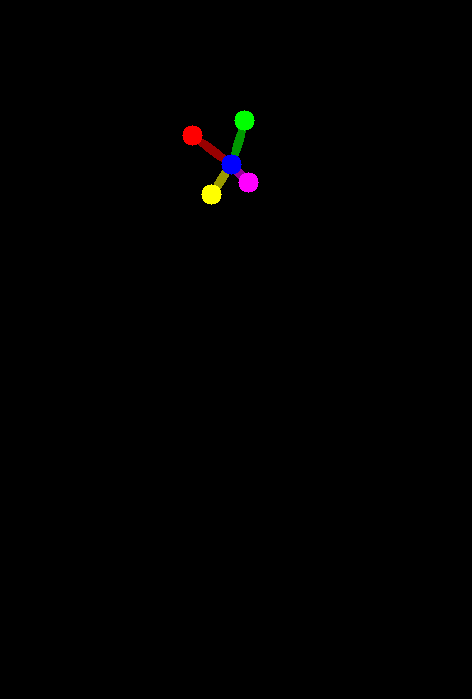

None
699
472


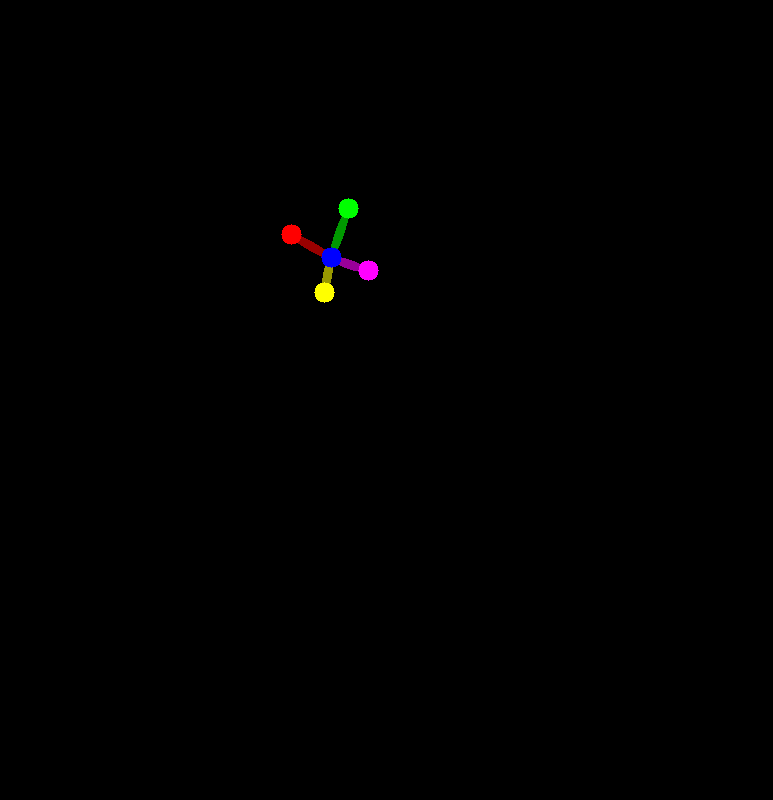

None
800
773


In [14]:
print(type(default_result[0].face_embedding))
print(default_result[0].face_embedding.shape)
print(default_result[0].face_keypoints.show())
print(default_result[0].height)
print(default_result[0].width)
print(default_result[1].pose_keypoints.show())
print(default_result[1].height)
print(default_result[1].width)

In [9]:
original_default_det_result = get_face_and_pose_info_from_images(
    "antelopev2",
    "/Data/Models/Diffusion/InstantX",
    data_sub_dirs.Public / "Images" / "Playboy" / "LennaSjööblom_LenaForsén" / "qShFGgyfM2o8OTptV6bGyf_9QVDc7x2ua38DJyWci9nsRi8u2ZJunn27MMP8vji6wZmUna5cR7TDxpC_p1wrzVinINlkVsl8tB6JY3RF81L9bAU38H4N-EQwDtEWWUT2.jpeg",
    data_sub_dirs.Public / "Images" / "Playboy" / "TeddiSmith" / "tumblr_oythctEdBF1wykvxvo1_1280.jpg",
    det_size=640)

NameError: name 'get_face_and_pose_info_from_images' is not defined

<class 'numpy.ndarray'>
(512,)


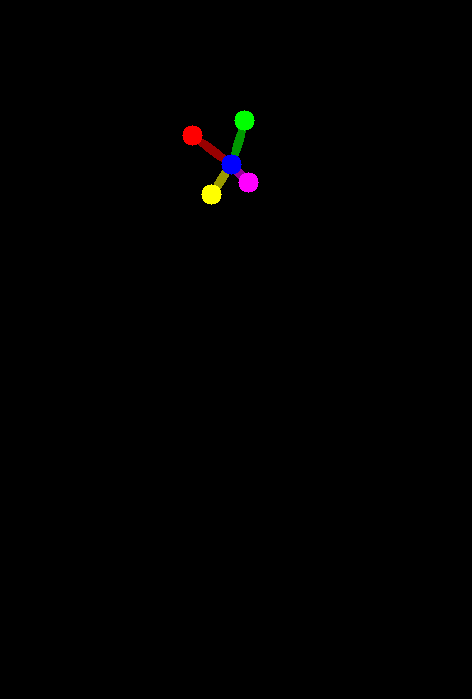

None
699
472


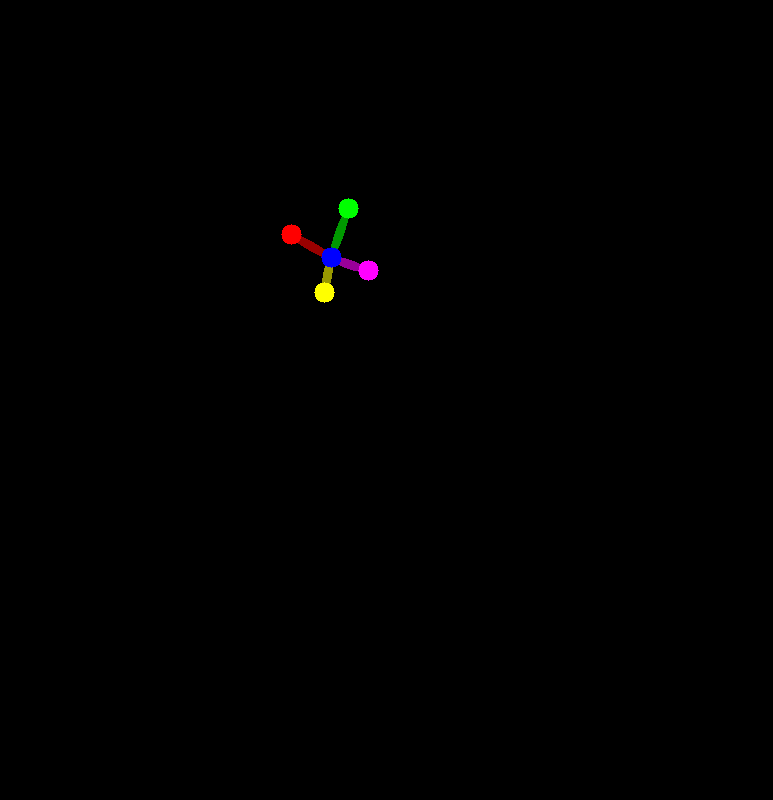

None
800
773


In [16]:
print(type(default_result[0].face_embedding))
print(default_result[0].face_embedding.shape)
print(default_result[0].face_keypoints.show())
print(default_result[0].height)
print(default_result[0].width)
print(default_result[1].pose_keypoints.show())
print(default_result[1].height)
print(default_result[1].width)

In [7]:
#def get_pose_information(model_name, model_root_directory, image_path):
    """
    By creating an object for FaceAnalysisWrapper, which wraps FaceAnalysis, within this function, the
    object goes out of scope once the function is done.
    """
#    face_analysis_wrapper = FaceAnalysisWrapper(model_name, model_root_directory)
#    pose_information = face_analysis_wrapper.get_pose_info_from_image(
#        image_path)
#    return pose_information

In [4]:
#pose_information = get_pose_information(
#    "antelopev2",
#    "/Data/Models/Diffusion/InstantX",
#    data_sub_dirs.Public / "Images" / "Playboy" / "TeddiSmith" / "U6S88ytE0BQ.jpg")

#print(type(pose_information))
#print(type(pose_information.pose_keypoints))
#print(pose_information.height)
#print(pose_information.width)
#pose_information.pose_keypoints.show()

In [5]:
#face_analysis_wrapper = FaceAnalysisWrapper("antelopev2", "/Data/Models/Diffusion/InstantX")

In [4]:
#pose_information = face_analysis_wrapper.get_pose_info_from_image(
#    data_sub_dirs.Public / "Images" / "Playboy" / "TeddiSmith" / "U6S88ytE0BQ.jpg")
#print(type(pose_information))
#print(type(pose_information.pose_keypoints))
#print(pose_information.height)
#print(pose_information.width)
#pose_information.pose_keypoints.show()

In [ ]:
pose_inform